# Feature Engineering

In [1]:
import sys
import pandas as pd
sys.path.append('../')
from utils.engineering import Transformations, FeaturesSelection
from utils.visualizations import extract_skewness_summary

# Data

In [2]:
df = pd.read_csv("./Data/clean_air_system_previous_years.csv")
df = df.drop(columns=["cd_000"])
df.head()

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,0,126,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [3]:
transformations = Transformations()

# Features Distributions

In [4]:
outliers_before = transformations.top_n_outliers(df, "class")
print(f"Number of columns with outliers: {len(outliers_before)}")

Number of columns with outliers: 161


In [5]:
df_transformed, log_columns, cubic_columns = transformations.columns_transformations(df.copy(), "class")

In [6]:
outliers_after = transformations.top_n_outliers(df_transformed, "class")

In [7]:
sorted_results = transformations.sort_results(outliers_before, outliers_after)
print(f"Number of columns that had the number of outliers changed: {len(sorted_results)}")
for column, reduced in sorted_results:
    if reduced < 0:
        print(f"Column {column}: Outliers increased by {abs(reduced)}")
        continue
    print(f"Column {column}: Outliers reduced by {reduced}")

Number of columns that had the number of outliers changed: 115
Column ba_008: Outliers reduced by 12781
Column dx_000: Outliers reduced by 12261
Column ag_009: Outliers reduced by 12187
Column cz_000: Outliers reduced by 11746
Column ee_009: Outliers reduced by 11525
Column cm_000: Outliers reduced by 11428
Column al_000: Outliers reduced by 11236
Column bz_000: Outliers reduced by 11017
Column am_0: Outliers reduced by 10971
Column cn_002: Outliers reduced by 10511
Column eb_000: Outliers reduced by 10377
Column az_006: Outliers reduced by 10083
Column ag_004: Outliers reduced by 9855
Column bc_000: Outliers reduced by 9228
Column az_003: Outliers reduced by 9123
Column co_000: Outliers reduced by 8641
Column du_000: Outliers reduced by 8469
Column cp_000: Outliers reduced by 8462
Column av_000: Outliers reduced by 8376
Column ay_005: Outliers reduced by 8299
Column bf_000: Outliers reduced by 7823
Column ba_009: Outliers reduced by 7575
Column bd_000: Outliers reduced by 7547
Column 

In [8]:
_, summary_df = extract_skewness_summary(df_transformed, "class")
summary_df

,count,skew_mean
skew_type,,
Negatively Skewed,46,-0.842808
Normal,36,-0.082658
Positively Skewed,79,7.194284


### Observations:
- All columns have outliers
- When applying the best statistical transformation to each column, getting the lowest possible skew, we saw that 115 columns had the numbers of outliers changed
- Out of those 115 columns, only four of them had the number of outliers increase
- With the correct transformations, we now have a dataframe with 46 negatively skewed columns and a low skew mean. 36 columns are now considered normally distributed, and the number of positively skewed columns dropped to 79, but the skew mean is still high

# Feature Selection

## PCA and ANOVA analysis

In [9]:
feature_selector = FeaturesSelection(df_transformed, "class")

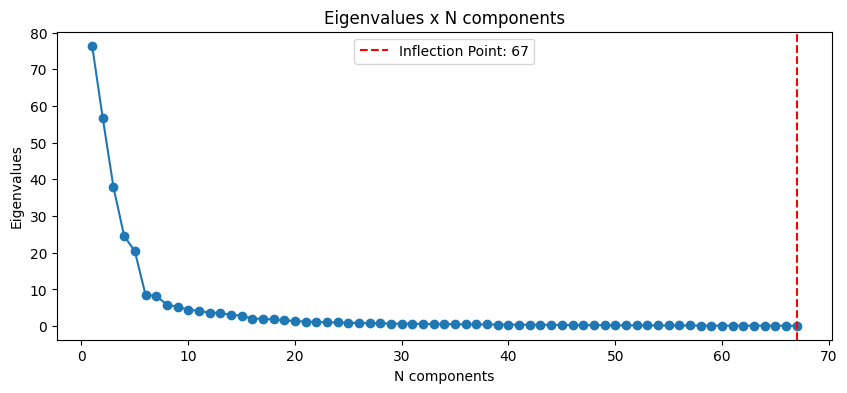

In [10]:
feature_selector.fit_pca(n_components=0.99)

In [11]:
feature_selector.select_features_anova(log_columns, cubic_columns)

### Observations:
- Since the dataframe still has 161 columns, a combination of PCA and ANOVA was used to find what features to keep
- For the PCA, n_components was 0.99, meaning that we want to retain 99% of the data variance
- Since there's a lot of outliers, even after the statistical transformations, RobustScaler was used to scale the dataframe before fitting the PCA
- As we can see from the graph, the inflection point where we retain 99% of the data variance is with 67 features
- N components is used as the k value for the ANOVA test to select the 67 most important features of the dataframe
- Four lists of columns were created. They will be saved as two dictionaries as pkl files to be used in the preprocessor

# Saving the files

### Two pkl files are saved into the folder **artifacts**. These files are dictionaries, with the keys being log_columns and cubic_columns, and the values being the column lists. With this, we can use it in the preprocessor during the model training step, to optimize the code. Also, with these files, we can test to see if reducing the dimension of the dataframe with PCA and ANOVA had big impacts on the performance of the models

In [12]:
feature_selector.save_mappings()